# Feature Importance and Selection Report

In [1]:
from featimp import *

### Heart Attack Possibility Dataset

In [2]:
df = pd.read_csv("data/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The dataset contains a subset of features from the Heart Disease Data Set from the UC Irvine Machine Learning Repository used to predict the likelihood of heart attacks.

Here are the descriptions for the features and target in this dataset:
- age
- sex
-  cp = chest pain type (4 values)
-  trestbps = resting blood pressure
-  chol = serum cholestoral in mg/dl
-  fbs = fasting blood sugar > 120 mg/dl
-  restecg = resting electrocardiographic results (values 0,1,2)
-  thalach = maximum heart rate achieved
-  exang = exercise induced angina (1 means yes, 0 means no)
-  oldpeak = ST depression induced by exercise relative to rest
- slope = the slope of the peak exercise ST segment
-   ca = number of major vessels (0-3) colored by flourosopy
-   thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
-   target: 0= less chance of heart attack 1= more chance of heart attack

### Spearman Rank Correlation Coefficient

The Spearman Rank Correlation Coefficient is a statistic that assesses how well the relationship between 2 variables correlates with each other. The Spearman Correlation is calculated using the Pearson correlation of the rank values of the 2 variables. Below is the equation for it:
$$\frac{cov(R(X), R(Y))}{\sigma_{R(X)}\sigma_{R(Y)}}$$ 
- $\sigma$ are the standard deviations of the rank variables
- $cov(R(X), R(Y))$ is the covariance of the rank variables

<br>
The resulting values would range from -1 to 1 with 1 being a fully similar correlation and -1 being a fully opposed correlation. This value can be used to determine the strength and direction of the monotonic relationship between the features and the target. The larger absolute value of the Spearman Rank Correlation Coefficient signifies a stronger relationship between the features and targets so the most important features should have a high absolute values. 

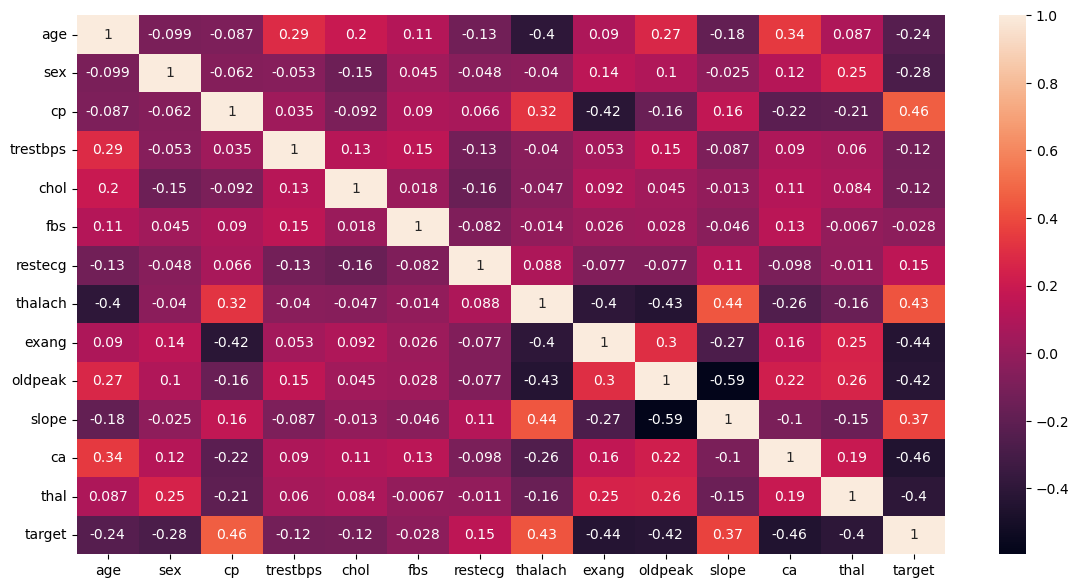

In [3]:
corr = df.corr(method="spearman")

fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(corr, annot=True)
plt.show()

From the heatmap above, I can see that 'cp' and 'thalach' has the highest positive correlation while 'ca' and 'exang', 'oldpeak', and 'thal' has the largest negative correlation with the target. It is important to note that Spearman Rank Correlation Coefficients are based on single-feature relevance importance so it works well for independent features but not when there are codependent features. Codependent features tend to have similar ranks even though only one of them should be considered 'important'.

### Principal Component Analysis (PCA)

PCA is a method used for dimensionality reduction, a technique used to reduce the amount of features in a dataset while preserving the most important information. It can indirectly identify the most important features by identifying the features that contribute significant sources of variation in the data. In a high-dimensional dataset where some features can be correlated, PCA can identify a smaller set of uncorrelated components that explain most of the variation in the data. <br> <br>

How does PCA work? When performing PCA, the principal components that explain the most variance in the data are selected. Each principal component is a linear combination of the original features, so the weightings of the original features in each PC can be used to identify the features that contribute most to that component. The higher the weightings, the higher the contributions.

In [4]:
X = df[
    [
        "age",
        "sex",
        "cp",
        "trestbps",
        "chol",
        "fbs",
        "restecg",
        "thalach",
        "exang",
        "oldpeak",
        "slope",
        "ca",
        "thal",
    ]
]
y = df["target"]

Looking at the cumulative percentage of variance explained, I would need to keep the first 8 PCA components to explain 79.5% of the variance.

In [5]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = PCA()
x_new = pca.fit_transform(X)
pca.explained_variance_ratio_
per_var = 100 * pca.explained_variance_ratio_
labels = ["PC" + str(x) for x in range(1, len(per_var))]
np.cumsum(per_var)

array([ 21.25405312,  33.07476085,  42.48117853,  51.56691325,
        59.42819432,  66.88985484,  73.52654658,  79.49535719,
        85.02555337,  89.80686249,  93.88459145,  97.13953284,
       100.        ])

Based on the 8 principal components, the features that contribute the most variance are 'oldpeak', 'trestbps', 'sex', 'slope', 'ca', 'restecg', 'fbs'.

In [6]:
pca_df = pca_feat_importance(X, 8, df)
pca_df

,0,1
0,PC0,oldpeak
1,PC1,trestbps
2,PC2,sex
3,PC3,slope
4,PC4,ca
5,PC5,restecg
6,PC6,fbs
7,PC7,trestbps


### Model Feature Selection

SelectFromModel is a sklearn transformer that can be used along any estimator to assign the importance of each feature. I have set the threshold for removal of unimportant features to be 1.25*median.

In [7]:
X = df[
    [
        "age",
        "sex",
        "cp",
        "trestbps",
        "chol",
        "fbs",
        "restecg",
        "thalach",
        "exang",
        "oldpeak",
        "slope",
        "ca",
        "thal",
    ]
]
y = df["target"]

Try fitting with a Logistic regression with L2 regularization. The most important features are 'sex', 'cp', 'exang', 'ca', 'thal'.

In [8]:
model_feat_selector(LogisticRegression(penalty="l2"), X, y)

['sex', 'cp', 'exang', 'ca', 'thal']

Below is a ranking of all the feature importance, with 'sex' being the strongest feature and 'chol' being the least importance feature.

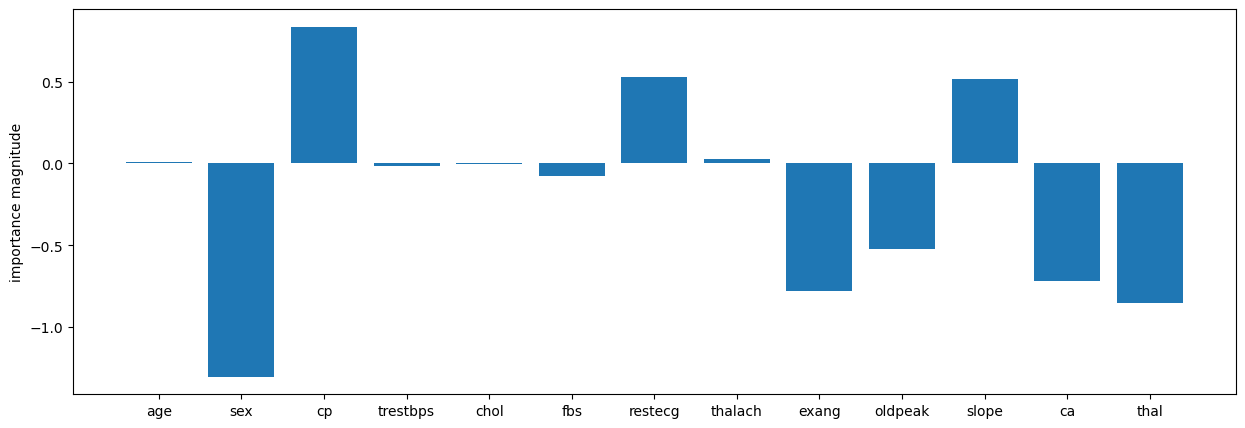

In [9]:
model = LogisticRegression(penalty="l2")
model.fit(X, y)
importance = model.coef_[0]
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(X.columns, importance)
ax.set_ylabel("importance magnitude")
plt.show()

Try fitting with a random forest. The most important features are 'cp', 'thalach', 'oldpeak', 'ca'.

In [10]:
model_feat_selector(RandomForestClassifier(n_estimators=1000), X, y)

['cp', 'thalach', 'oldpeak', 'ca', 'thal']

Below is a ranking of all the feature importance, with 'cp' being the strongest feature and 'fbs' being the least importance feature.

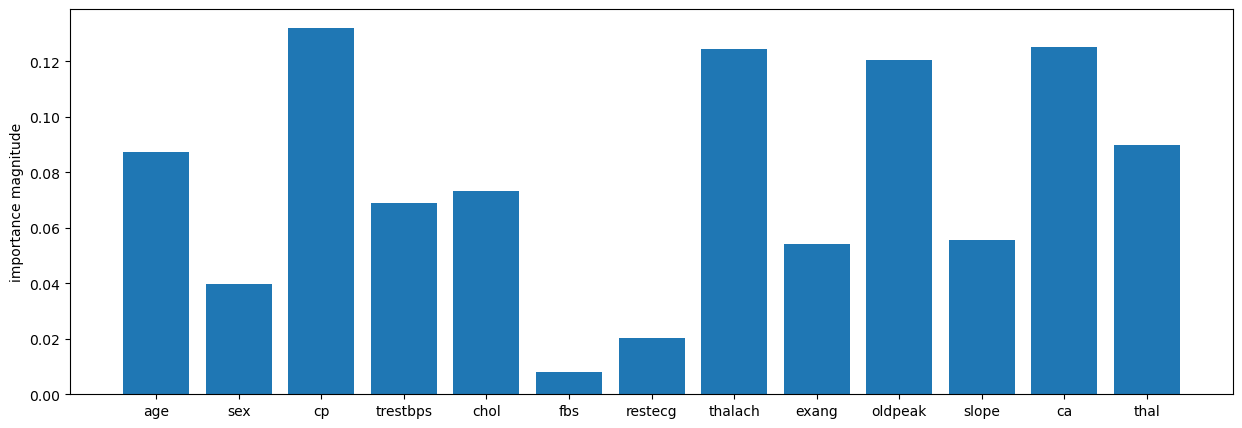

In [11]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)
importance = model.feature_importances_
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(X.columns, importance)
ax.set_ylabel("importance magnitude")
plt.show()

Try fitting with a XGBoost model. All features are considered important by the model.

In [12]:
model_feat_selector(
    XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=9,
        colsample_bytree=0.2,
        reg_alpha=3,
        reg_lambda=1,
    ),
    X,
    y,
)

['cp', 'exang', 'slope', 'ca', 'thal']

Below is a ranking of all the feature importance, with 'cp' being the strongest feature and 'fbs' being the least importance feature.

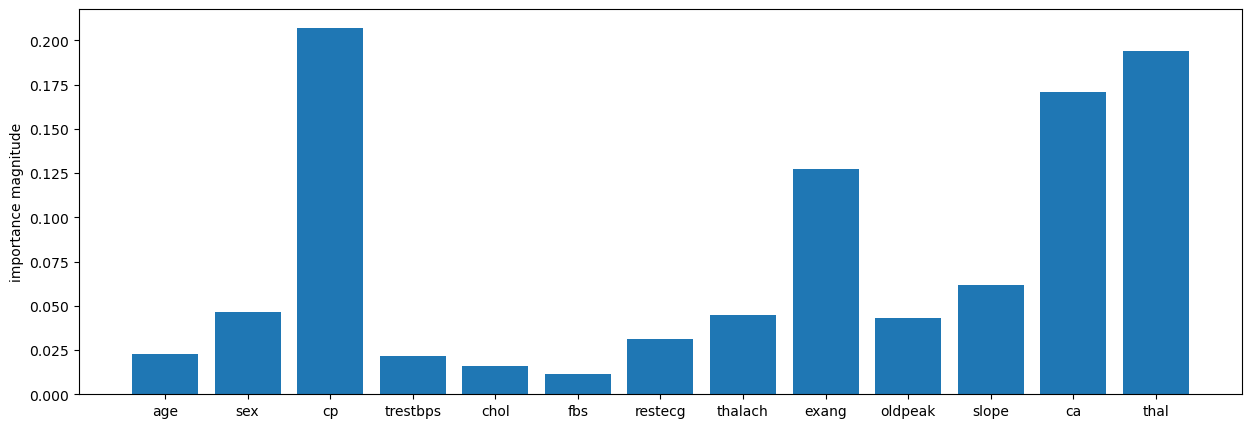

In [13]:
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=9,
    colsample_bytree=0.2,
    reg_alpha=3,
    reg_lambda=1,
)

model.fit(X, y)
importance = model.feature_importances_
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(X.columns, importance)
ax.set_ylabel("importance magnitude")
plt.show()

### Evaluation of the Features selected by each method

Let's seperate the complete dataset into 5 datasets with the features selected from each method. I will conduct a 10-fold cross validation on each set of features with the given model to determine which sets of features are important and give the best model performance.

In [14]:
spearman_x = df[["cp", "thalach", "ca", "exang", "oldpeak", "thal"]]
pca_x = df[["oldpeak", "trestbps", "sex", "slope", "ca", "restecg", "fbs"]]
log_x = df[["sex", "cp", "exang", "ca", "thal"]]
rf_x = df[["cp", "thalach", "oldpeak", "ca", "thal"]]
xgb_x = df[["cp", "exang", "slope", "ca", "thal"]]

First, lets see how a Logistic regression with L2 regularization performs on the 5 sets of features. I will be using accuracy of classification as the metric. The features selected by Spearman Rank Correlation Coefficient seems to have the best performance while PCA had the worst performance.

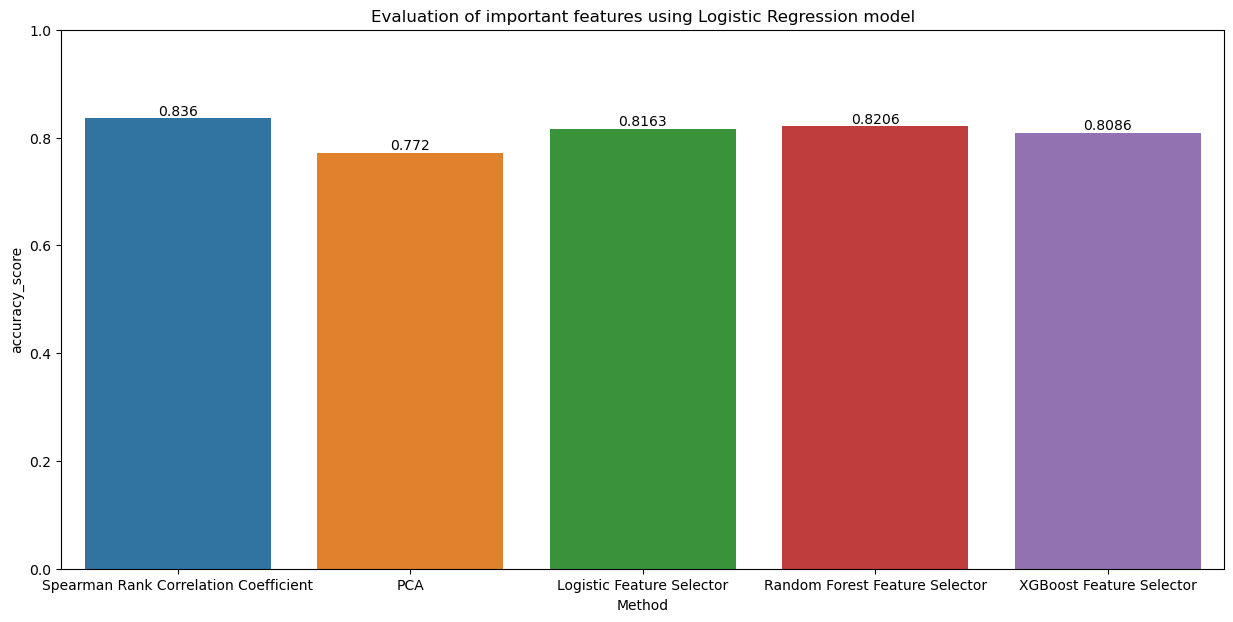

In [15]:
model = LogisticRegression(penalty="l2")
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
score_df = create_score_df(model, cv, spearman_x, pca_x, log_x, rf_x, xgb_x, y)
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x=score_df["Method"], y=score_df["accuracy_score"], ax=ax)
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_title("Evaluation of important features using Logistic Regression model")
ax.set_ybound(0, 1)

Next, I will use a Random Forest Classifier model and see how it performs on the 5 sets of features. Again, I will use accuracy as the metric for model performance. The features selected by XGBoost feature selector seems to have the best performance while PCA had the worst performance again.

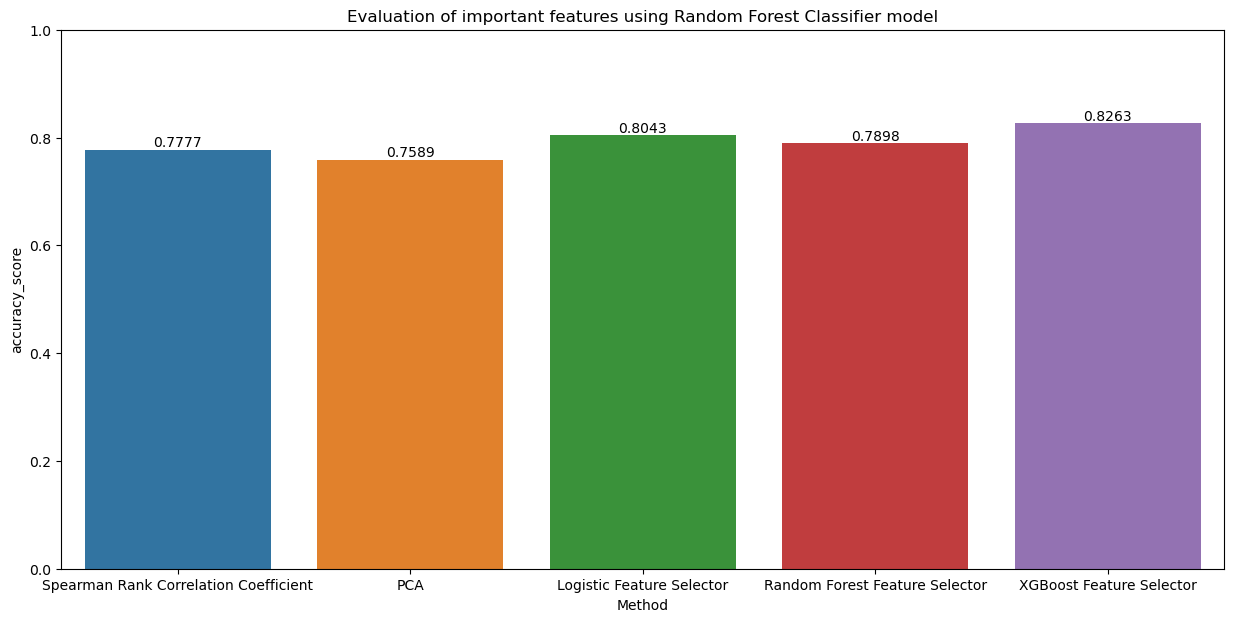

In [16]:
model = RandomForestClassifier(n_estimators=1000)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
score_df = create_score_df(model, cv, spearman_x, pca_x, log_x, rf_x, xgb_x, y)
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x=score_df["Method"], y=score_df["accuracy_score"], ax=ax)
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_title("Evaluation of important features using Random Forest Classifier model")
ax.set_ybound(0, 1)

Lastly, I will use a XGboost model and see how it performs on the 5 sets of features. Again, I will use accuracy as the metric for model performance. The features selected by XGBoost feature selector seems to have the best performance while PCA had the worst performance again.

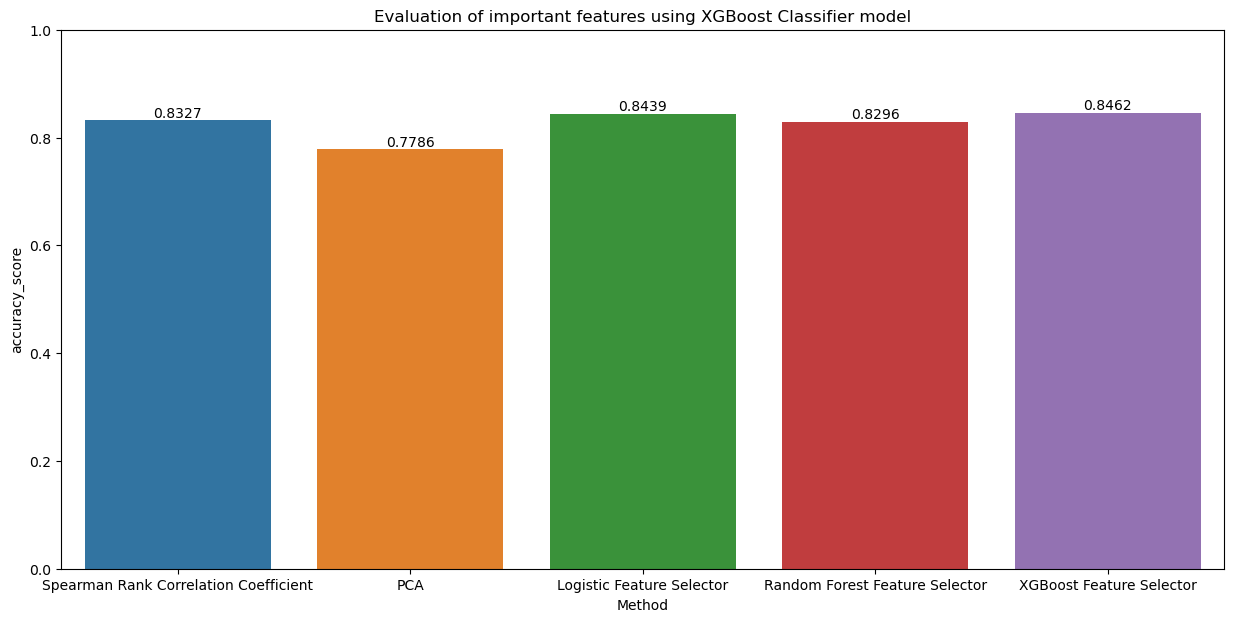

In [17]:
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=9,
    colsample_bytree=0.2,
    reg_alpha=3,
    reg_lambda=1,
)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
score_df = create_score_df(model, cv, spearman_x, pca_x, log_x, rf_x, xgb_x, y)
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x=score_df["Method"], y=score_df["accuracy_score"], ax=ax)
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_title("Evaluation of important features using XGBoost Classifier model")
ax.set_ybound(0, 1)

Out of all the features in the 5 sets of features, 'cp' and 'ca' appear in all of them are deemed the most important features, followed by 'thal' which were selected in 4 out of the 5 sets of feature importance selection methods.

### SHAP

Shapley Additive explanations(SHAP) is a mathematical method for explaining the outputs of machine learning models. It is based on game theory and shows how a feature influences the predictions of a single row relative to the other features in that row. The magnitude of the effects and the direction of the SHAP values determine the importance of the feature and if they increase or decrease the value prediction of the output.

In [18]:
df = pd.read_csv("data/heart.csv")

In [19]:
X = df.drop(['target'], axis=1)
y = df['target']

model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=9,
    colsample_bytree=0.2,
    reg_alpha=3,
    reg_lambda=1,
)

In [20]:
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [21]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

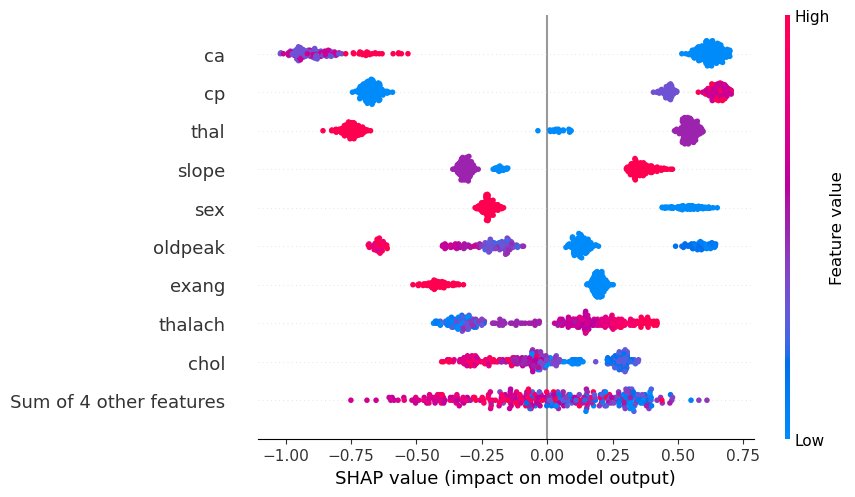

In [26]:
shap.plots.beeswarm(shap_values)

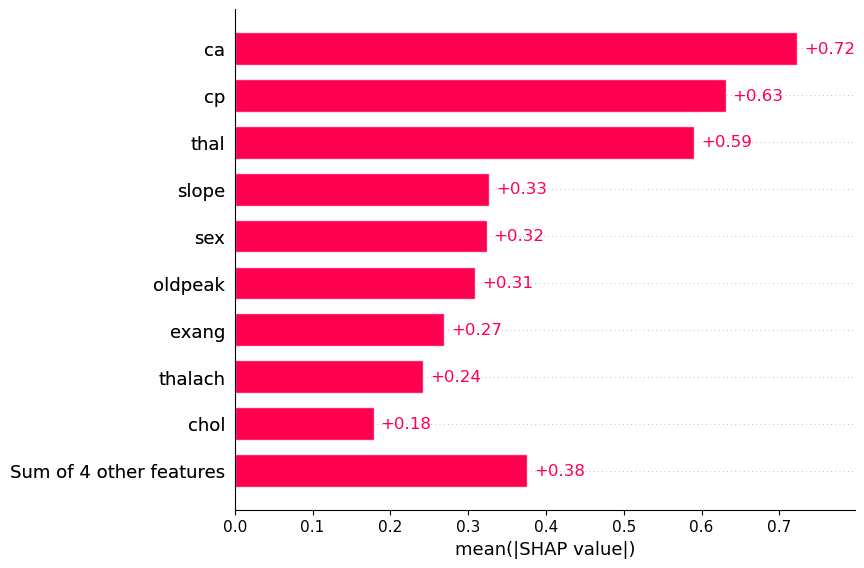

In [27]:
shap.plots.bar(shap_values)

Seems like 'ca', 'cp', and 'thal' are the most important features according to SHAP.